In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [15]:
folder = "energies"
num_replicas = 8
max_points = 10009

# Gráficas

In [17]:
def plotObservables(temp: int, folder: str, show=True, save=False, figsize=(25, 10)):
    """
    Plots the time series of energy and magnetization at a specific replica index.
    Now supports files where each line contains: energy magnetization
    """
    filename = os.path.join(folder, f"energies_{temp}.txt")
    temperature = 0
    energies = []
    magnetizations = []

    with open(filename, 'r') as file:
        lines = file.readlines()
        temperature = float(lines[0].strip())
        for line in lines[1:max_points + 1]:
            try:
                energy, magnetization = map(float, line.strip().split())
                energies.append(energy)
                magnetizations.append(magnetization)
            except ValueError:
                print(f"Warning: Skipping malformed line: {line.strip()}")

    plt.figure(figsize=figsize)

    # Subplot for Energy
    plt.subplot(2, 1, 1)
    plt.plot(energies, label=f"T = {temperature:.3f}", color='tab:blue')
    plt.ylabel("Energy")
    plt.title(f"Energy evolution at T = {temperature:.3f} (first {max_points} steps)")
    plt.grid(True)

    # Subplot for Magnetization
    plt.subplot(2, 1, 2)
    plt.plot(magnetizations, label=f"T = {temperature:.3f}", color='tab:red')
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Magnetization")
    plt.title(f"Magnetization evolution at T = {temperature:.3f} (first {max_points} steps)")
    plt.grid(True)

    plt.tight_layout()

    if save:
        plots_folder = "plots"
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f"energy_magnetization_plot_T{temp}.png")
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")

    if show:
        plt.show()
    else:
        plt.close()


In [18]:
for i in range(num_replicas):
    plotObservables(i, folder, False, True)

Plot saved to plots\energy_magnetization_plot_T0.png
Plot saved to plots\energy_magnetization_plot_T1.png
Plot saved to plots\energy_magnetization_plot_T2.png
Plot saved to plots\energy_magnetization_plot_T3.png
Plot saved to plots\energy_magnetization_plot_T4.png
Plot saved to plots\energy_magnetization_plot_T5.png
Plot saved to plots\energy_magnetization_plot_T6.png
Plot saved to plots\energy_magnetization_plot_T7.png


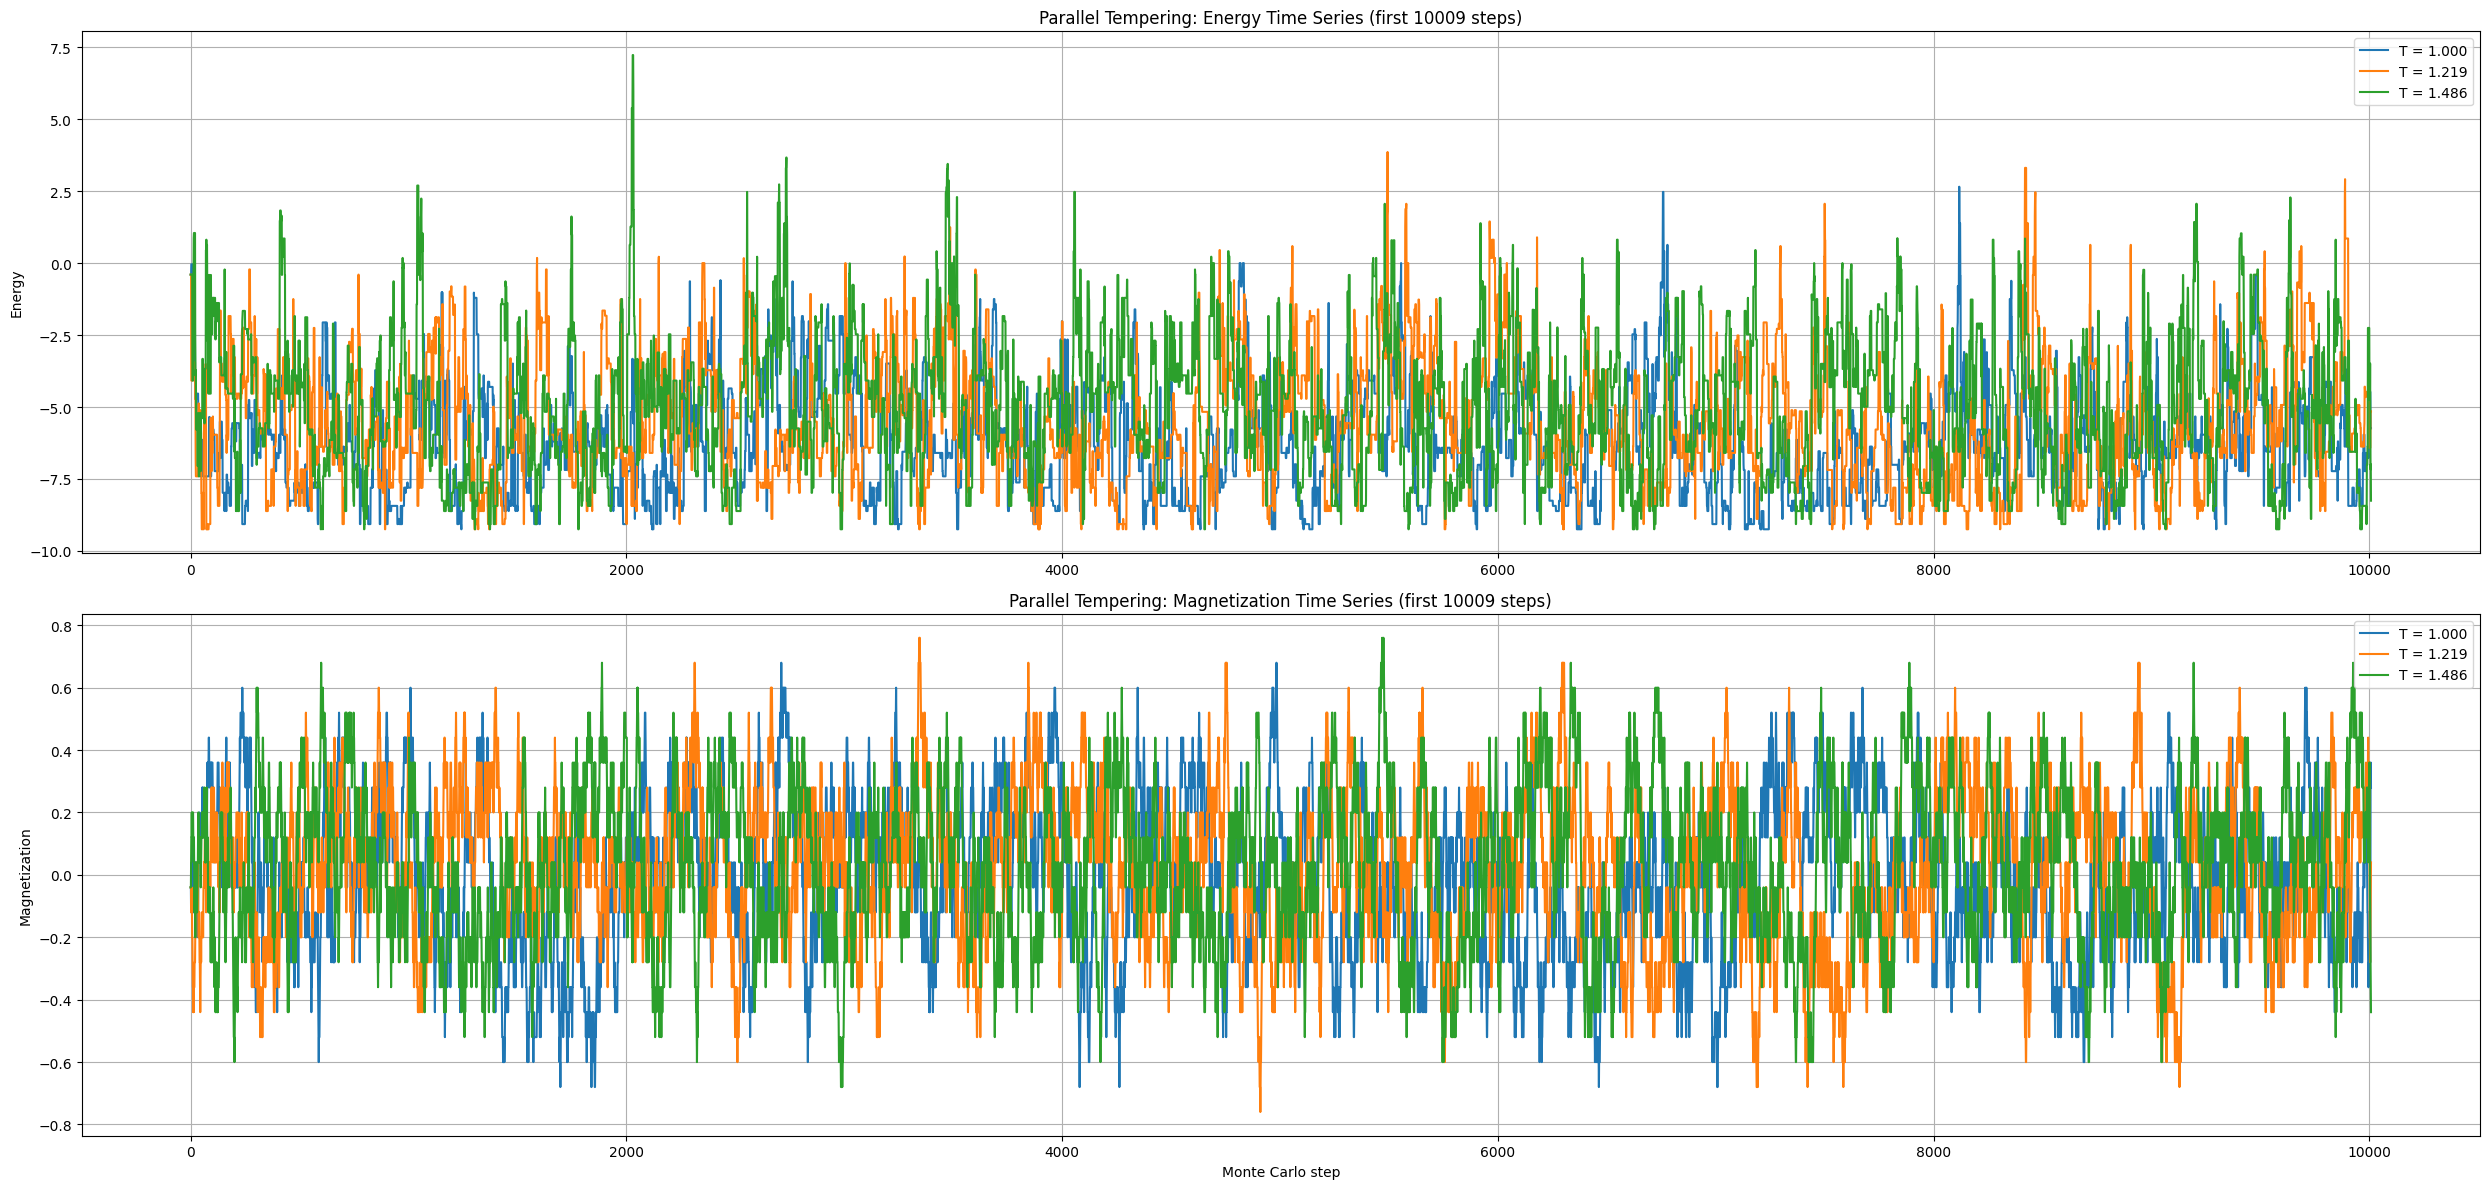

In [19]:
replicas_to_plot = 3

energy_data = []
magnetization_data = []
temperatures = []

for i in range(replicas_to_plot):
    filename = os.path.join(folder, f"energies_{i}.txt")
    with open(filename, 'r') as file:
        lines = file.readlines()
        temperature = float(lines[0].strip())
        energies = []
        magnetizations = []
        for line in lines[1:max_points + 1]:
            try:
                energy, magnetization = map(float, line.strip().split())
                energies.append(energy)
                magnetizations.append(magnetization)
            except ValueError:
                print(f"Warning: Skipping malformed line in {filename}: {line.strip()}")
        temperatures.append(temperature)
        energy_data.append(energies)
        magnetization_data.append(magnetizations)

# Plotting
plt.figure(figsize=(25, 12))

# Energy subplot
plt.subplot(2, 1, 1)
for i in range(replicas_to_plot):
    plt.plot(energy_data[i], label=f"T = {temperatures[i]:.3f}")
plt.ylabel("Energy")
plt.title(f"Parallel Tempering: Energy Time Series (first {max_points} steps)")
plt.legend()
plt.grid(True)

# Magnetization subplot
plt.subplot(2, 1, 2)
for i in range(replicas_to_plot):
    plt.plot(magnetization_data[i], label=f"T = {temperatures[i]:.3f}")
plt.xlabel("Monte Carlo step")
plt.ylabel("Magnetization")
plt.title(f"Parallel Tempering: Magnetization Time Series (first {max_points} steps)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Autocorrelación

Para un observable A(t), la función de autocorrelación es:

$$
C_A(\tau) = \frac{\langle A(t)A(t + \tau) \rangle - \langle A(t) \rangle ^2}{\langle A(t) ^2 \rangle - \langle A(t)  \rangle ^2}
$$

El tiempo de autocorrelación nos da la cantidad de Monte Carlo Sweeps (MCS) que hay que hacer para que dos elementos de la cadena de Markov no estén correlacionados (o al menos no fuertemente?). Se calcula:

$$
\tau^{int}_{auto} = \frac{1}{2} + \sum_{\tau = 1}^{\infty} C_A(\tau)
$$

Como no podemos sumar hasta infinito, sumamos hasta ```max_lag```.





In [20]:
def calculateAutocorrelation(observable, max_lag: int):
    """
    Calcula autocorrelación *normalizada* hasta max_lag.

    energies: array que representa la secuencia de energías
    max_lag: entero hasta el que se considera tau
    """
    N = len(observable)
    mean = np.mean(observable)
    var = np.var(observable)

    C = np.zeros(max_lag)
    for tau in range(max_lag):
        C[tau] = np.mean((observable[:N - tau] - mean) * (observable[tau:] - mean)) / var
    return C

def integrated_time(C):
    """
    calcula la integrated auto correlation en base a la autocorrelación normalizada.

    C: array de autocorrelaciones
    """
    tau_int = 0.5
    for tau in range(1, len(C)):
        if C[tau] <= 0: break
        tau_int += C[tau]
    return tau_int

def autocorrelation_and_integrated_time_by_replica(folder: str, max_lag: int):
    for i in range(num_replicas):
        filename = os.path.join(folder, f"energies_{i}.txt")
        with open(filename, 'r') as file:
            lines = file.readlines()
            temperature = float(lines[0].strip())
            energies = []
            magnetizations = []
            for line in lines[1:max_points + 1]:
                try:
                    e, m = map(float, line.strip().split())
                    energies.append(e)
                    magnetizations.append(m)
                except ValueError:
                    continue  # skippear línea si hay errores o algo así

        energies = np.array(energies)
        magnetizations = np.array(magnetizations)

        C_E = calculateAutocorrelation(energies, max_lag)
        C_M = calculateAutocorrelation(magnetizations, max_lag)

        tau_E = integrated_time(C_E)
        tau_M = integrated_time(C_M)

        print(f"Replica {i} (T = {temperature:.3f}):")
        print(f"  Integrated time for Energy:        τ_int = {tau_E:.2f}")
        print(f"  Integrated time for Magnetization: τ_int = {tau_M:.2f}")


In [21]:
autocorrelation_and_integrated_time_by_replica(folder, 30)

Replica 0 (T = 1.000):
  Integrated time for Energy:        τ_int = 16.78
  Integrated time for Magnetization: τ_int = 19.77
Replica 1 (T = 1.219):
  Integrated time for Energy:        τ_int = 16.36
  Integrated time for Magnetization: τ_int = 19.15
Replica 2 (T = 1.486):
  Integrated time for Energy:        τ_int = 14.49
  Integrated time for Magnetization: τ_int = 17.72
Replica 3 (T = 1.811):
  Integrated time for Energy:        τ_int = 12.72
  Integrated time for Magnetization: τ_int = 15.96
Replica 4 (T = 2.208):
  Integrated time for Energy:        τ_int = 11.77
  Integrated time for Magnetization: τ_int = 12.27
Replica 5 (T = 2.692):
  Integrated time for Energy:        τ_int = 9.69
  Integrated time for Magnetization: τ_int = 12.72
Replica 6 (T = 3.281):
  Integrated time for Energy:        τ_int = 10.96
  Integrated time for Magnetization: τ_int = 12.54
Replica 7 (T = 4.000):
  Integrated time for Energy:        τ_int = 9.12
  Integrated time for Magnetization: τ_int = 11.69
